### Example 5: Using the simple forward model to test TCCON-like retrievals -- Weak CO$_2$ band as example
Part of ESE 156 Remote Sensing Class;
Christian Frankenberg
__________
The purpose of this exercise is to use the simple forward model developed in Example 4 to actually perform retrievals using a synthetic measurement.

This is now going into Bayesian inversion using prior information, for which the Rodgers book is really needed to fully understand it!

Things you will learn (and need to remember) in this and the coming notebooks:
- Prior state $x_a$ and prior covariance matrix $S_a$
- Bayes' theorem, impact of prior knowledge
- Averaging kernel matrix $A$
- Smoothing error
- Forward model error
- Degrees of freedom (DOF)




In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
figsize(10,8)

##### Reading in saved HDF5 file from last exercise
This is just a convenient way of re-importing the variables (and I bet you will stumble over HDF5 files at one point in your student life or may now actually think about using this format for saving your own data instead of using an Excel spreadsheet :-)).

In [2]:
# Read in the cross sections from example 3:
import h5py as h5
# Open up a file (will be generate if non-existent)
f = h5.File('Data/crossSections_weakBand.h5')
# Save the most important variables we would like to keep:
cs_matrix_co2 = f['CrossSections/cs_matrix_co2'][:]
cs_matrix_ch4 = f['CrossSections/cs_matrix_ch4'][:]
cs_matrix_h2o = f['CrossSections/cs_matrix_h2o'][:]
VCD_dry = f['Profiles/VCD_dry'][:]
vmr_h2o = f['Profiles/vmr_h2o'][:]
nu = f['wavenumberGrid'][:]
Tsolar = f['Tsolar'][:]
pressure = f['Profiles/p'][:]
f.close()

Now let us define the forward model again, this time with a full state vector and a general setup class + most importantly compute the Jacobian matrix on the fly


In [3]:
# Convenient way of passing multiple arguments in one class (similar to F.bla = bla in Matlab):
# Creating an empty class (won't go into full object oriented programming here though, just a dirty trick of misusing classes)
class Setup:
    pass
mySetup = Setup()

# Set some variables here:

# Just assuming something here for now:
mySetup.FWHM = 0.05
# Let us focus on one CO2 band for now
mySetup.nu_out = np.arange(6150,6280,0.02)
mySetup.sza = 45.0
mySetup.VCD_dry = VCD_dry
# Try to restrict the forward model to a smaller range now:
wo = np.where((nu>mySetup.nu_out[0]-20)&(nu<mySetup.nu_out[-1]+20))[0]
# Save wavenumber grid and cross section matrices just for the small range here:
mySetup.nu_in = nu[wo]
mySetup.cs_co2 = cs_matrix_co2[wo,:]
mySetup.cs_ch4 = cs_matrix_ch4[wo,:]
mySetup.cs_h2o = cs_matrix_h2o[wo,:]
mySetup.Tsolar = Tsolar[wo]
mySetup.vcdDry = VCD_dry

nuo = mySetup.nu_out
# Check dimensions:
print(mySetup.cs_co2.shape, mySetup.nu_out.shape )

(16998, 72) (6500,)


### Defining the state vector $x$:
This might seem a bit clumsy in the beginning but we have to find a way to represent all our target inversion variables in the state vector (the VMRs of all trace gases and some polynomial coefficients). This can (should) of course be done more elegantly (e.g. you can create dictionaries that help match the names of variables to the state vector, etc, so that things can be changed in a flexible way). For now, we are lazy and define our state vector in a rather fixed way (and the forward model currently assumes it to be like that).

In [4]:
# Now let us define the state vector x
x = np.zeros((3*72+3,))
# It is basically the VMRs stacked in the vector
x[0:72] = 400.e-6     # CO2 in ppm
x[72:2*72] = 1900.e-9 # CH4 in ppb
x[2*72:3*72]= vmr_h2o # from model!

# Last: The polynomial coefficients at the end of the state vector!
poly = [1e-7,-0.01,25]
x[3*72:] = poly
# Check this if you want!
#print(x)

## Computing Forward model and Jacobian K
What we are trying to do now is to write a function that can evaluate the Forward model but also compute its Jacobian if needed. In principle, one could compute the Jacobian numerically but this would require evaluating the Forward model with a perturbed state vector (one for each) and choosing the right step-size to compute the derivative numerically 
$$\frac{\partial F(x)}{\partial x_i} = \frac{F(x+\Delta x_i)-F(x)}{\Delta x_i}$$
or better a two-point formula:
$$\frac{\partial F(x)}{\partial x_i} = \frac{F(x+\Delta x_i)-F(x-\Delta x_i)}{2\Delta x_i}$$

Let's go back to our forward model, which includes the computation of the transmission of the atmosphere along a slant light-path from the sun to the observer on the ground, multiplied with a low-order polynomial to account for any other effect such as scattering in the atmosphere, spectral shape of Black body of solar spectrum, detector sensitivity, etc. (it just bunches up all these effects without a real physical meaning here):
$$F(x) = <I_o\cdot\exp\left(-AMF\cdot\sum_{i=0}^n x_i\cdot VCD^{dryAir}_i\cdot \sigma_i(\nu)\right)\cdot \sum_{i=n+1}^{n+1+polyDegree}x_i\cdot \nu^{i-(n+1)}>$$ 
with $x_{i\dots n}$ being the the $VMRs$ and $x_{i+n\dots n+1+polyDegree}$ the coefficients for the polynomial. The operator $<>$ denotes the instrument operator (instrument line shape ILS), including the convolution of the high resolution transmission and resampling to the detector wavenumber grid:
$$<I>(\nu_1) = \int_{-\infty}^{\infty}I(\nu)\cdot ILS(\nu_1-\nu)d\nu$$
or in its discrete form
$$<I>(\nu_1) = \sum_{\nu=-\nu_1-\Delta}^{\nu_1+\Delta}I(\nu)\cdot ILS(\nu_1-\nu)\,,$$
where we can choose a width $\Delta$ over which the convolution will be applied (typically just the range over which the ILS is finite). The above didn't yet include the resampling to the detector ($y$) grid but this is just an interpolation anyhow (a down-sampling from a higher resolution grid to the actual nmeasurement grid). If the ILS is not changing over the entire fitting range, we can make use of the convolution theorem, which states that under suitable conditions the Fourier transform of a convolution is the pointwise product of Fourier transforms (otherwise, we often need a bute-force convolution, which can cost time). 

What we need to compute as well is the Jacobian Matrix $K$, which is defined as the derivative of the forward model with respect to $x$:

$$K = {dF(x) \over dx} = 
\left\vert\matrix{{\partial F_1(x) \over \partial x_1} & {\dots} & {\partial F_1(x) \over \partial x_n} \cr 
{\vdots} & {\ddots } & {\vdots} \cr 
{\partial F_m(x) \over \partial x_1} & {\dots} & {\partial F_m(x) \over \partial x_n}}\right\vert\,.$$

In our simplified forward model, we can actually compute the derivatives analytically. For the state vector elements with a $VMR$, the derivative will be:
$${\partial F(x) \over \partial x_i} = <F(x)\cdot -AMF \cdot VCD^{dryAir}_i\cdot \sigma_i(\nu)>$$

<font color='red'>**Question:**</font> Can you perform this differentiation? 
<font color='red'>**Question:**</font> Can you show how this linearizes $\log(F(x)$ and basically provides the DOAS method if the convolution can be ignored?



In [5]:
# Import a Gaussian convolution
from scipy.ndimage.filters import gaussian_filter1d
# Import a 1D interpolation routine
from scipy.interpolate import interp1d

# write a separate function to just apply the instrument function (as we do this often:) 
# This could be more sophisticated than a Gaussian line-shape. 
# If we have it in a separate function, things can be easily replaced.
def applyInstrument(F,b):
    co = 2.355
    res = b.nu_in[1]-b.nu_in[0]
    F2 = gaussian_filter1d(F, b.FWHM/res/co)
    finter = interp1d(b.nu_in, F2,kind='linear')
    return finter(b.nu_out)
    
def ForwardModel(x, b,compK=False):
    # Now we have to basically know what is in the state vector x as well as ancillary (fixed) parameters in b
    vmr_co2 = x[0:72]
    vmr_ch4 = x[72:2*72]
    vmr_h2o = x[2*72:3*72]
    poly = x[3*72:]
    # Compute total optical thickness
    total_od = np.sum(b.cs_co2*vmr_co2*b.vcdDry,1)+np.sum(b.cs_ch4*vmr_ch4*b.vcdDry,1)+np.sum(b.cs_h2o*vmr_h2o*b.vcdDry,1)
    # Compute Air Mass Factor given SZA
    AMF = 1./np.cos(b.sza/180.*np.pi)
    # Compute transmission
    T = b.Tsolar*np.exp(-AMF*total_od)
    # Multiply with our baseline polynomial
    dnu = b.nu_in-np.mean(b.nu_in)
    F = T*np.polyval(poly, dnu)
    
    # Compute Jacobian Matrix K if needed analytically here (will go through this in class):
    if compK:
        K = np.zeros((len(b.nu_out),len(x)))
        # Go through different Species:
        for i in np.arange(0,72,1):
            dFdx = AMF*F*-b.cs_co2[:,i]*b.vcdDry[i]
            K[:,i] = applyInstrument(dFdx,b)
        j = 0
        for i in np.arange(72,2*72,1):
            dFdx = AMF*F*-b.cs_ch4[:,j]*b.vcdDry[j]
            K[:,i] = applyInstrument(dFdx,b)
            j+=1
        j = 0
        for i in np.arange(2*72,3*72,1):
            dFdx = AMF*F*-b.cs_h2o[:,j]*b.vcdDry[j]
            K[:,i] = applyInstrument(dFdx,b)
            j+=1
        # Polynomials here:
        K[:,72*3]   = applyInstrument(T*dnu**2,b);
        K[:,72*3+1] = applyInstrument(T*dnu,b);
        K[:,72*3+2] = applyInstrument(T,b);
    if compK:
        return applyInstrument(F,b),K
    else:
        return applyInstrument(F,b)

#### Let's run the forward model and Jacobian generation
Now we can actually run the forward model, including the computation of the Jacobi matrix K in a single line:

In [6]:
F1,K = ForwardModel(x,mySetup,True)

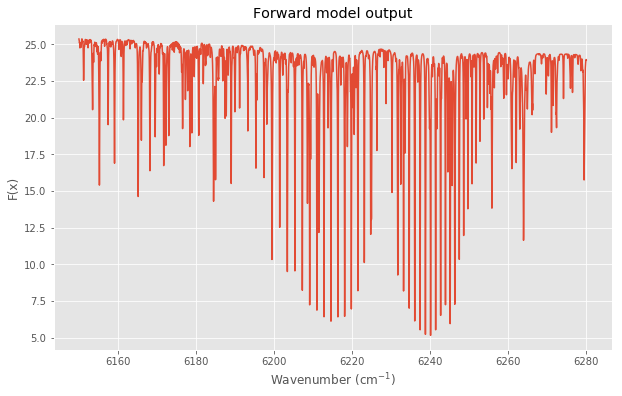

In [7]:
figsize(10,6)
plt.plot(mySetup.nu_out, F1)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('F(x)')
plt.title('Forward model output')

### Let us now take a look at some of the elements in the Jacobi Matrix. 
#### Trace gas derivatives:

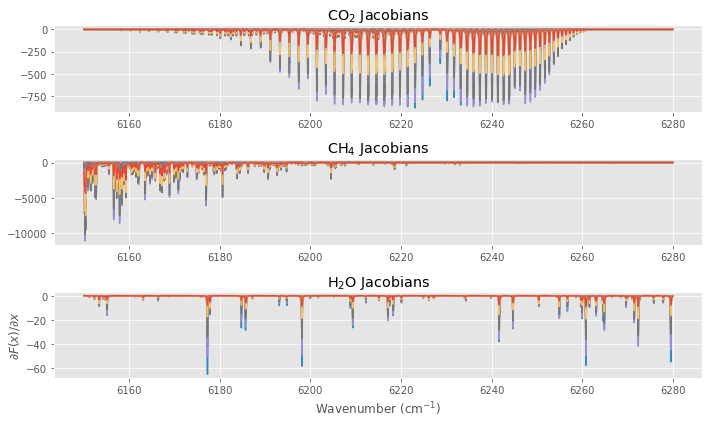

In [8]:
figsize(10,6)
plt.subplot(311)
plt.plot(mySetup.nu_out, K[:,0:72:5])
plt.title('CO$_2$ Jacobians')
plt.subplot(312)
plt.plot(mySetup.nu_out, K[:,72:72*2:5])
plt.title('CH$_4$ Jacobians')
plt.subplot(313)
plt.plot(mySetup.nu_out, K[:,72*2:72*3:5])
plt.title('H$_2$O Jacobians')
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('$\partial F(x)/\partial x$')
plt.tight_layout()

#### Trace gas (just CO2 for 2 layers, normalized by the VCD per layer):
<font color='red'>**Question:**</font> If the state vector element is VMR in each layer, what does the normalization with the dry air VCD do then (i.e. the normalized plot is equivalent to the derivative with respect to what?) 

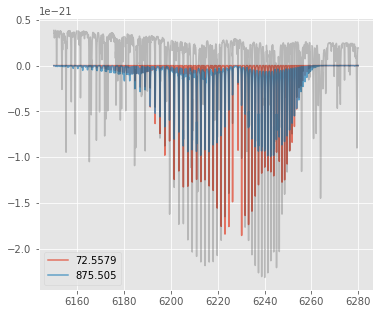

In [24]:
plt.plot(mySetup.nu_out, K[:,35]/VCD_dry[35],alpha=0.75,label=pressure[35])
plt.plot(mySetup.nu_out, K[:,65]/VCD_dry[65],alpha=0.75,label=pressure[65])
plt.plot(mySetup.nu_out, (F1/25)/0.3e21-3e-21,'k',alpha=0.2)
plt.legend()

In [10]:
#### Polynomial coefficients:

(6500, 219)


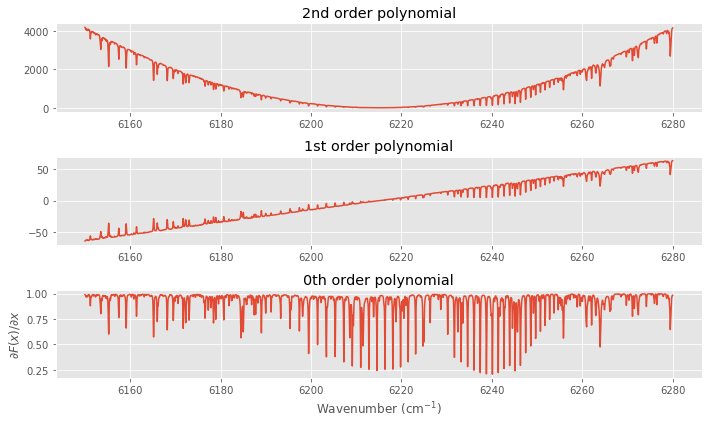

In [11]:
print(K.shape)
figsize(10,6)
plt.subplot(311)
plt.plot(mySetup.nu_out, K[:,3*72])
plt.title('2nd order polynomial')
plt.subplot(312)
plt.plot(mySetup.nu_out, K[:,3*72+1])
plt.title('1st order polynomial')
plt.subplot(313)
plt.plot(mySetup.nu_out, K[:,3*72+2])
plt.title('0th order polynomial')
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('$\partial F(x)/\partial x$')
plt.tight_layout()

### Perturbing the forward model
What we can do now is change the state vector at a particular layer (like a small perturbation in the VMR of a trace gas at one specific layer only) and add some noise to it. Here, we just add 50ppm of CO2 into a couple of layers close to the surface and see how the retrieval will react. 

8.18459855035e+21


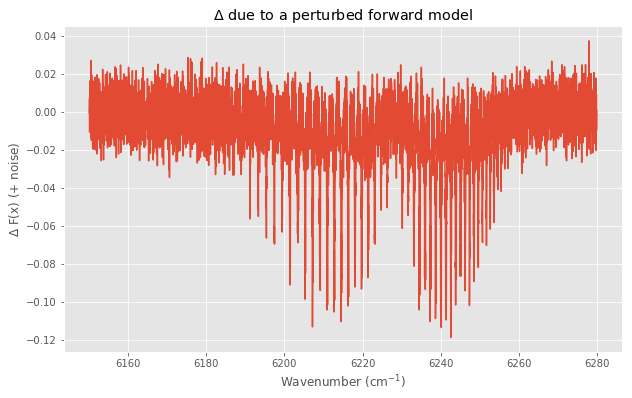

In [12]:
# Perturb the forward model:
print(VCD_dry.T.dot(x[0:72]))
# Which index to change (arbitrary choice here, used 65 here)
index = 65
x2 = x.copy()
dx = 50e-6
# Perturb by 50ppm
x2[index:72] = x[index:72]+dx
# Assume some noise level (fixed values across the entire range here)
noise = 0.01

F2 = ForwardModel(x2,mySetup)+np.random.randn(len(nuo))*noise
plt.plot(nuo, ((F2-F1)))
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('$\Delta$ F(x) (+ noise)')
plt.title('$\Delta$ due to a perturbed forward model')

#### Perturbing the forward model nearby our known state
Before we move on to fully non-linear retrievals, we assume for now that the model behaves linearly around the state we are looking at if the changes are small. This way, we can still perform a linear retrieval as described before, but just doing:
$$y-F(x)=K\cdot\Delta x$$
where we now retrieved the $\Delta$ in the state vector from the state that we used to compute $F(x)$. This way, we can use the same normal equations to solve the above.

In [53]:
# Naive fitting
# And the Seps matrix, the measurement error covariance:
invSe = np.zeros((len(nuo),len(nuo)))

for i in np.arange(0,len(nuo),1):
   invSe[i,i]=1./(noise**2) 

delta_x = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe).dot(F2-F1)
print(h[0:72].T.dot(delta_x[0:72]))

5.05887899826e-06


(6500, 219)


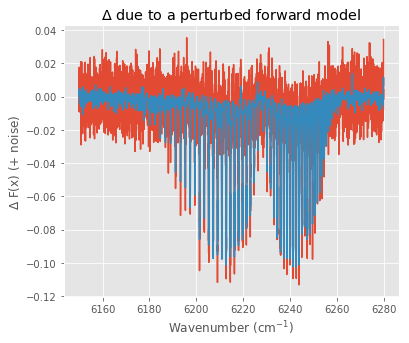

In [54]:
# Plot fit:
plt.plot(nuo, ((F2-F1)))
plt.plot(nuo, K.dot(delta_x))
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('$\Delta$ F(x) (+ noise)')
plt.title('$\Delta$ due to a perturbed forward model')

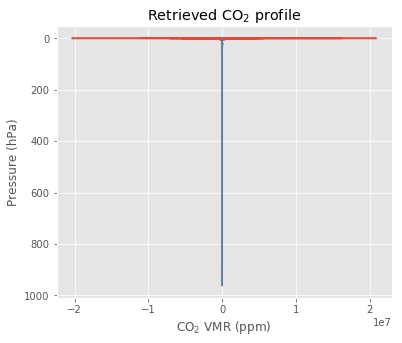

In [55]:
plt.plot((x[0:72]+delta_x[0:72])*1e6, pressure)
plt.plot((x[0:72]*1e6), pressure)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('CO$_2$ VMR (ppm)')
plt.title('Retrieved CO$_2$ profile')

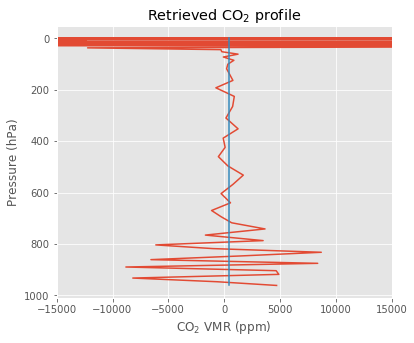

In [60]:
plt.plot((x[0:72]+delta_x[0:72])*1e6, pressure)
plt.plot((x[0:72]*1e6), pressure)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('CO$_2$ VMR (ppm)')
plt.xlim((-15000,15000))
plt.title('Retrieved CO$_2$ profile')

### Why is this so bad?
Ok, this simple inversion was really bad and messed up the retrieved state vector with many unphysical values. 

Why did this happen and how can we salvage this? The inversion is unstable (not enough information to solve the state vector) and we need to regularize the problem, a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting. There are different ways of doing this but for now, we will focus on using actual prior information and the Bayes Theorem (see Rodger's, pages 22ff):
$$P(x|y) = \frac{P(y|x)P(x)}{P(y)}$$

Using Gaussian uncertainties, we can express mismatches in the measurement space as well as the state vector space, if we assume some prior knowledge as to how the state vector "should" behave, characterized by it's prior $x_a$ (mean expected state) as well as its variance-covariance matrix $S_a$:
$$-2\ln P(y|x) = (y-Kx)^T S_{\epsilon}^{-1}(y-Kx)+c_1$$
and 
$$-2\ln P(x) =  (x-x_a)^T S_{a}^{-1}(x-x_a)+c_2\,,$$
with the prior covariance matrix $S_a$ representing the expected value 
$$S_a = \mathbf{E}\left(x-x_a)(x-x_a)^T\right)$$

If we assume $P(y)$ to just be a normalising factor, we can rewrite $-2\ln P(x|y)$ as
$$-2\ln P(x|y) = (y-Kx)^T S_{\epsilon}^{-1}(y-Kx) + (x-x_a)^T S_{a}^{-1}(x-x_a) + c_3$$

If we want to maximize $P(x|y)$, we just have to minimize the right hand side of the equation, which is almost exactly the same we found for the normal least squares approach apart from the added cost function induced by our prior knowledge: $(x-x_a)^T S_{a}^{-1}(x-x_a)$. 

As shown in Rodgers, the retrieved state vector $\hat{x}$ is now:
$$\hat{x} = x_a + (K^TS_\epsilon^{-1}K+S_a^{-1})^{-1}K^TS_\epsilon^{-1}(y-Kx_a)\,$$
for which we can replace $Kx_a$ with $F(x_a)$ as done in our case. 

What can we use as prior information for the CO$_2$ mixing ratio now? We know that it is a long-lived gas and its variations are rather small, with an overall seasonal amplitude of only 10-20ppm (around a background of 400ppm). We also know that changes in its concentrations are usually coorelated in between nearby atmospheric layers (vertically). So we could construct some covariance matrix based on a fixede relative percentage on the diagonal but adding correlations on the off-diagonal (feel free to play around!). 

In the example below, we just assume a 20% uncertainty on the diagonal and then multiply the variances with a exp(-dp/300) factor, which provides a correlation as a function of pressure difference between layers (one could use real model data to try to generate a proper covariance matrix but here we use just this). 

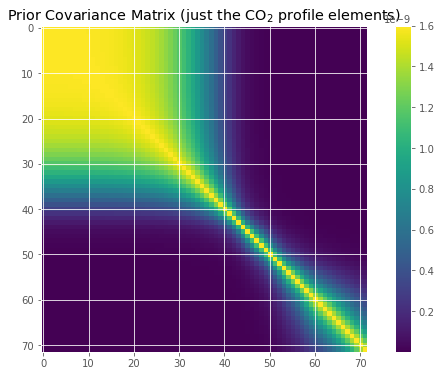

In [16]:
# Add prior information:
Sa = np.zeros((len(x),len(x)))

# Say we have a 1% uncertainty for all prior trace gas concentrations:
for i in np.arange(0,72*3,1):
    Sa[i,i]=(0.15*x[i])**2
for i in np.arange(0,72,1):
    Sa[i,i]=(0.1*x[i])**2
    for j in np.arange(0,72,1):
        dp = np.abs(pressure[i]-pressure[j])
        Sa[i,j]=Sa[i,i]*np.exp(-dp/100.) # *0.9999#
        Sa[j,i]=Sa[i,i]*np.exp(-dp/100.) # *0.9999#
# For the polynomials
Sa[72*3,72*3]=1e-3**2
Sa[72*3+1,72*3+1]=1e-2**2
Sa[72*3+2,72*3+2]=1**2
plt.imshow(Sa[0:72,0:72],cmap='viridis')
plt.title('Prior Covariance Matrix (just the CO$_2$ profile elements)')
plt.colorbar()

#### Computing Posterior error covariance, Gain matrix and Averaging Kernel:
We can compute the Gain matrix and posterior error covariance as before, just with $\hat{S}^{-1}$ now being
$$\hat{S}^{-1} = K^TS_\epsilon^{-1}K+S_a^{-1}\,$$
(see Rodgers).

We can also compute the Averaging Kernel Matrix $A$,
$$AK = {\partial \hat{x} \over \partial x} = GK$$
This can be seen as $\Delta F(x)$ is $K(x-x_a)+\epsilon$, thus
$$\hat{x} = G[K(x-x_a)+\epsilon] = GK(x-x_a)+G\epsilon$$

It is important to fully understand the meaning of the A matrix as it is instrumental in understanding the measurement sensitivity and later comparisons against model data (for instance). The A matrix (nxn) represents the derivative of the retrieved state vector $\hat{x}$ with respect to a true change in the state vector $x$. E.g. we can solve the question what would happen to the state vector if CO$_2$ in reality changes at only one layer at say 800hPa or 300hPa.
$$A = {\partial \hat{x} \over \partial x} = \left\vert\matrix{{\partial \hat{x}_1 \over \partial x_1} & {\dots} & {\partial \hat{x}_1 \over \partial x_n} \cr 
{\vdots} & {\ddots } & {\vdots} \cr 
{\partial \hat{x}_n \over \partial x_1} & {\dots} & {\partial \hat{x}_n \over \partial x_n}}\right\vert\,.$$

The rows of the $A$ basically show how a specific retrieved state vector element $\hat{x}_i$ reacts to true changes of the state vector at different positions $x_i$ while the columns of the $A$ show how the overal state vector $\hat{x}$ reacts to a perturbation of the true state in one singular position $x_i$. This is reflected in the columns of the $A$ while the rows reflect the change in the retrieved state vector at particular index $i$ vs. a change in the true state at all other positions. 
In the ideal case, the $A$ would be unity on the diagonal and zero elsewhere, indicating a perfect retrieval.

In [17]:
S = np.linalg.inv(K.T.dot(invSe).dot(K)+np.linalg.inv(Sa))
Gain = np.linalg.inv(K.T.dot(invSe).dot(K)+np.linalg.inv(Sa)).dot(K.T).dot(invSe)
A = Gain.dot(K)
# Column weighting function h
h = np.zeros((len(x),))
h[0:72] = VCD_dry/np.sum(VCD_dry)

65
Prior XCO2 assumption:  400.0
Fitted XCO2:  405.089528719
True XCO2:  405.149505256
Uncertainty in XCO2:  0.0663984156284
Prior Uncertainty in XCO2:  17.284403895


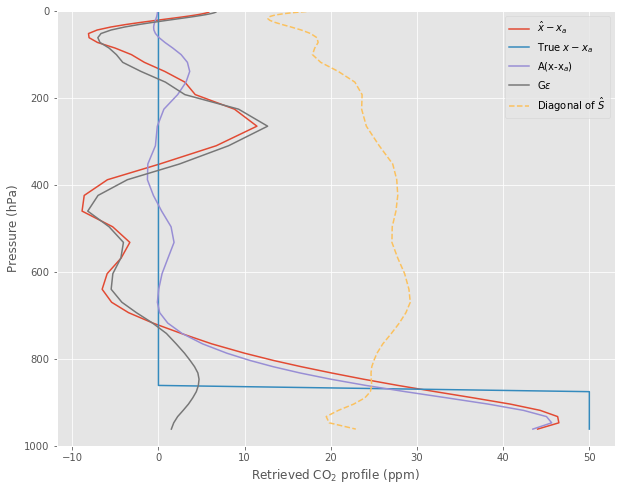

In [18]:
print(index)
figsize(10,8)
F2 = ForwardModel(x2,mySetup)
eps = np.random.randn(len(nuo))*noise#/100000.
F2 += eps
# Compute model response to noise vector
Geps = Gain.dot(eps)
# Compute updated state vector
xhat = x + Gain.dot(F2-F1)
# Copy prior 
xa = x.copy()
# Compute A(x_true-x_a)
Ax_xa = A.dot(x2-xa)
#plt.subplot(211)
plt.plot( 1e6*(xhat[0:72]-xa[0:72]),pressure,label='$\hat{x}-x_a$')
plt.plot(1.e6*(x2[0:72]-x[0:72]),pressure,label='True $x-x_a$')
plt.plot( 1.e6*Ax_xa[0:72]+1,pressure,label='A(x-x$_a$)')
plt.plot( 1.e6*Geps[0:72],pressure,label='G$\epsilon$')
plt.plot( 1e6*np.sqrt(np.diag(S[0:72,0:72])),pressure,'--',label='Diagonal of $\hat{S}$')
plt.legend(loc=0)
plt.xlabel('Retrieved CO$_2$ profile (ppm)')
plt.ylabel('Pressure (hPa)')
plt.ylim((1000,0))

XCO2_uncertainty = np.sqrt(np.dot(np.dot(h.T, S), h))

XCO2_prior_uncertainty = np.sqrt(np.dot(np.dot(h.T, Sa), h))
print('Prior XCO2 assumption: ', VCD_dry.T.dot(x[0:72])/np.sum(VCD_dry)*1e6)
print('Fitted XCO2: ', VCD_dry.T.dot(xhat[0:72])/np.sum(VCD_dry)*1e6)
print('True XCO2: ', VCD_dry.T.dot(x2[0:72])/np.sum(VCD_dry)*1e6)
print('Uncertainty in XCO2: ', XCO2_uncertainty*1e6)
print('Prior Uncertainty in XCO2: ', XCO2_prior_uncertainty*1e6)


## A closer look at the averaging kernels
<font color='red'>**Question:**</font> What do the rows and columns of the averaging kernel mean (in your own words)? 


#### Rows of the averaging kernel

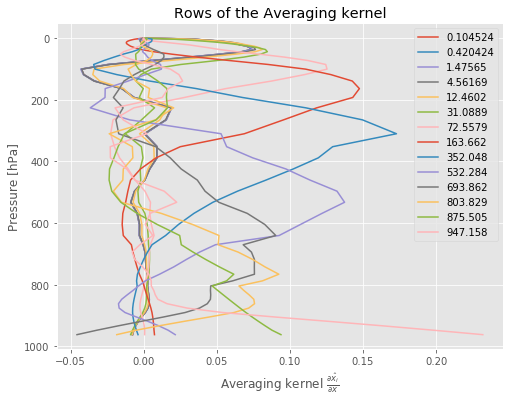

In [19]:
figsize(8,6)
for i in np.arange(5,72,5):
    plt.plot(A[i,0:72],pressure, label=pressure[i])
#plt.xlim((-0.05,0.25))    
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'Averaging kernel $\frac{\partial \hat{x_i}}{\partial x}$')
plt.ylabel('Pressure [hPa]')
plt.title('Rows of the Averaging kernel')

#### Columns of the averaging kernel

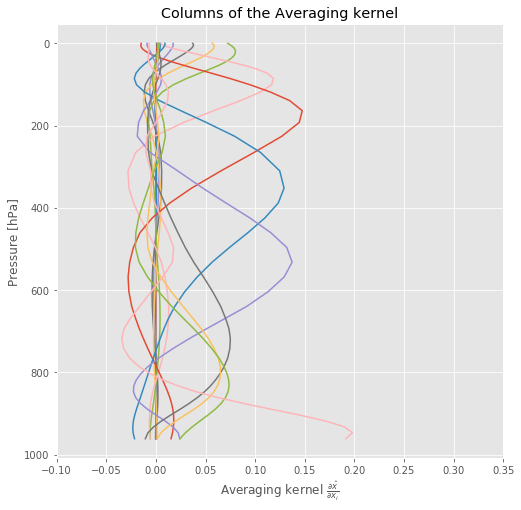

In [20]:
figsize(8,8)
for i in np.arange(5,72,5):
    plt.plot(A[0:72,i],pressure, label=pressure[i])
plt.xlim((-0.1,0.35))    
#plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'Averaging kernel $\frac{\partial \hat{x}}{\partial x_i}$')
plt.ylabel('Pressure [hPa]')
plt.title('Columns of the Averaging kernel')

#### Degrees of freedom for CO$_2$ profile
The degrees of freedom (DOF) is a metric for how many independent variables one can actually retrieve. It can be computed at the trace of the averaging kernel matrix.

Here, we can just look at the DOF for the CO2 retrievals (or the other trace gases). The is the trace of the averaging kernel matrix over the CO$_2$ state vector elements:

In [21]:
# CO2
print(np.trace(A[0:72,0:72]))
# CH4
print(np.trace(A[72:72*2,72:72*2]))
# H2O
print(np.trace(A[72*2:72*3,72*2:72*3]))

5.67089163063
1.77359505144
2.80496132369


#### Column averaging kernel 
We can define an operator h, which let's us compute the column averaged mixing ratio from the state vector CO$_2$ elements.
$$XCO_2 = h^T\hat{x}$$
In our case, h is just the mass-weighted contribution of each layer to the total column. It is 
$$ h = VCD_{dry}/\sum{VCD_{dry}}$$

With the averaging kernel $A$ as decsribed above, we can compute 
$$ \frac{\partial XCO_2}{\partial x_j} = (h^TA)_j$$

The column averaging kernel $cAK$ can then be computed as well, which is 
$$ cA_j = \frac{\partial XCO_2}{\partial XCO2_j} = \frac{\partial XCO_2}{\partial x_j \cdot h_j} = (h^TA)_j/h_j$$

And the variance in XCO$_2$ is given by 
$$\sigma^2(XCO_2) = h^T\hat{S}h$$

You can read up on random variables and transformations in the Image Processing Book by Bernd Jaehne (Chapter 3), located on the FTP (or a smaller writeup here: ftp://fluo.gps.caltech.edu/XYZT_ESE156/Reading/RandomVectors.pdf)

Assume you have a random variable vector $g$ (dimension P) with covariance $S_g$. If you convert $g$ into a new random variable vector $k$ (dimension Q) using the linear transform $M$ (a QxP matrix):
$$k = Mg\,,$$
then the covariance of $k$ ($S_k$) is 
$$S_k = MS_gM^T$$

You could use this equation for instance to proof that the error in the mean of uncorrelated errors goes down with $1/\sqrt(n)$ but not at all if errors are fully correlated. See Jaehne book. If you remember this one equation, it will remain very useful and is also the principle behind all the column averaging property calculations above for which we use the weighting function $h$ to convert a 72 dimensional random variable in the state vector to a 1D column averaged mixing ratio. 

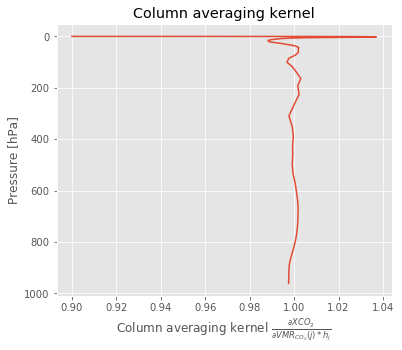

In [22]:
figsize(6,5)
cK = np.dot(h[0:72].transpose(), A[0:72,0:72])
#print(cK)
plt.plot(cK/h[0:72],pressure)
plt.gca().invert_yaxis()
plt.xlabel(r'Column averaging kernel $\frac{\partial XCO_2}{\partial VMR_{CO_2}(j)*h_j}$')
plt.ylabel('Pressure [hPa]')
plt.title('Column averaging kernel')

<font color='red'>**Question:**</font> What does the column averaging kernel represent (in your own words)? 